<a href="https://colab.research.google.com/github/HereBeCode/StanceDetectionML-Brockport/blob/main/MultiClass_YT_Comment_Sentiment_Classification_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import string
import re
import nltk
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from textblob import TextBlob

from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import  word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
filename = "/content/DataAbortion.csv"
df = pd.read_csv(filename, usecols=["commentTextDisplay", "Standing"], encoding="utf-8")
print(df)

                                    commentTextDisplay  Standing
0    But look at the other side with the adverse re...         0
1    I feel like if you don’t want to be vaccinated...         0
2                                 His body his choice.         0
3    I have an idea 💡  .. how about you leave peopl...         0
4    I respect your freedom of choice. My family me...         0
..                                                 ...       ...
942  The recovery rate is 99.8 % . Why are stupid l...         2
943  DON&#39;T GET VACCINATED !!!   Don&#39;t let t...         2
944  I&#39;d explain in detail the deaths and side ...         2
945  I am so happy to read the comments because I d...         2
946  I now personally know 3 people that have teste...         2

[947 rows x 2 columns]


In [ ]:
#Clean the text
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

def remove_html_and_other(text):
    new_text = re.sub(r'<a href.*\/a>', ' ', text)
    new_text = (new_text.replace('<br /', ' ').
                replace('&#39;', "'").
                replace('<br >', ' ').
                replace('<br>', ' ').
                replace('\u2026', ' ').
                replace('&quot;', '"').
                replace('1st', 'first ').
                replace('2nd', 'second ').
                replace('3rd', 'third ').
                replace('100%', 'one hundred percent ')
    )
    return new_text

def remove_non_alphabets(text):
    new_text = ""
    for x in range(len(text)):
        if(re.match('[a-zA-z\ ]+', text[x])):
            new_text += text[x]
    return new_text

def tokenize(sentence):
    new_sentence = nltk.word_tokenize(sentence)
    return new_sentence

def remove_stopwords(sentence):
    new_sentence = [word for word in sentence if not word in stop_words]
    return new_sentence

def lemmatize(sentence):
    new_sentence = [wordnet_lemmatizer.lemmatize(word) for word in sentence]
    return new_sentence

def cleanTxt(text):
  text = text.lower()
  text = remove_html_and_other(text)
  text = remove_non_alphabets(text)
  text = tokenize(text)
  text = remove_stopwords(text)
  text = lemmatize(text)
  text = TreebankWordDetokenizer().detokenize(text)

  return text

df['commentTextDisplay']=df['commentTextDisplay'].apply(cleanTxt)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
#Create a function to get the subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

#Create a function to get the polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

#Create two new columns
df['Subjectivity'] = df['commentTextDisplay'].apply(getSubjectivity)
df['Polarity'] = df['commentTextDisplay'].apply(getPolarity)

df

,commentTextDisplay,Standing,Subjectivity,Polarity
0,look side adverse reaction vaccine choose poison,0,0.000000,0.000000
1,feel like want vaccinated choice run hospital ...,0,0.000000,0.000000
2,body choice,0,0.000000,0.000000
3,idea leave people alone let make decision best...,0,0.300000,1.000000
4,respect freedom choice family member infected ...,0,0.384127,0.114286
...,...,...,...,...
942,recovery rate stupid libs pushing plan demic,2,1.000000,-0.800000
943,get vaccinated let college nerd liberal tell a...,2,0.319048,0.195238
944,explain detail death side effect uneffective r...,2,0.000000,0.000000
945,happy read comment see one favour poison keep ...,2,0.800000,0.516667


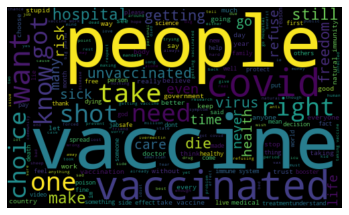

In [ ]:
# Plot Word Cloud
allWords = ' '.join( [comments for comments in df['commentTextDisplay']])
wordCloud = WordCloud(width = 500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.imshow(wordCloud,interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
#Create a function to compute the negative, neutral, and positive analysis
def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

df['Analysis'] = df['Polarity'].apply(getAnalysis)

df

,commentTextDisplay,Standing,Subjectivity,Polarity,Analysis
0,look side adverse reaction vaccine choose poison,0,0.000000,0.000000,Neutral
1,feel like want vaccinated choice run hospital ...,0,0.000000,0.000000,Neutral
2,body choice,0,0.000000,0.000000,Neutral
3,idea leave people alone let make decision best...,0,0.300000,1.000000,Positive
4,respect freedom choice family member infected ...,0,0.384127,0.114286,Positive
...,...,...,...,...,...
942,recovery rate stupid libs pushing plan demic,2,1.000000,-0.800000,Negative
943,get vaccinated let college nerd liberal tell a...,2,0.319048,0.195238,Positive
944,explain detail death side effect uneffective r...,2,0.000000,0.000000,Neutral
945,happy read comment see one favour poison keep ...,2,0.800000,0.516667,Positive


In [ ]:
#Print all of the positive comments
j=1
sortedDF = df.sort_values(by=['Polarity'])
for i in range(0, sortedDF.shape[0]):
  if sortedDF['Analysis'][i] == 'Positive':
    print(str(j) + ') ' + sortedDF['commentTextDisplay'][i])
    print()
    j = j+1

In [ ]:
#Print all negative comments
j=1
sortedDF = df.sort_values(by=['Polarity'], ascending='False')
for i in range(0, sortedDF.shape[0]):
  if sortedDF['Analysis'][i] == 'Negative':
    print(str(j) + ') ' + sortedDF['commentTextDisplay'][i])
    print()
    j = j+1

In [ ]:
#Print all neutral comments
j=1
sortedDF = df.sort_values(by=['Polarity'])
for i in range(0, sortedDF.shape[0]):
  if sortedDF['Analysis'][i] == 'Neutral':
    print(str(j) + ') ' + sortedDF['commentTextDisplay'][i])
    print()
    j = j+1

In [ ]:
#Plot the polarity and subjectivity
plt.figure(figsize=(8,6))
for i in range(0, df.shape[0]):
  plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color='Blue')

plt.title("Sentiment Analysis")
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [ ]:
df = df.drop(['Subjectivity'], axis=1)
df = df.drop(['Analysis'], axis=1)
x_data = df.drop(['Standing'], axis=1)
y_data = df['Standing'].values

In [ ]:
x_data.head()

,commentTextDisplay,Polarity
0,look side adverse reaction vaccine choose poison,0.000000
1,feel like want vaccinated choice run hospital ...,0.000000
2,body choice,0.000000
3,idea leave people alone let make decision best...,1.000000
4,respect freedom choice family member infected ...,0.114286


In [ ]:
#Prepare the train/test sets for SVM model
train_X, test_X, train_y, test_y = model_selection.train_test_split(df[["commentTextDisplay",'Polarity']],df["Standing"], test_size=0.20, random_state=1000)

tfidf_vect = TfidfVectorizer(max_features=2000)
text_train_X = tfidf_vect.fit_transform(train_X['commentTextDisplay']).toarray()
text_test_X = tfidf_vect.transform(test_X['commentTextDisplay']).toarray()
polarity_train_X = train_X['Polarity'].to_numpy()
polarity_train_X = polarity_train_X.reshape(len(polarity_train_X),1)
polarity_test_X = test_X['Polarity'].to_numpy()
polarity_test_X = polarity_test_X.reshape(len(polarity_test_X),1)
final_train_X = np.hstack((text_train_X, polarity_train_X))
final_test_X = np.hstack((text_test_X, polarity_test_X))



In [ ]:
#SVM Model
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(final_train_X, train_y)
predictions_SVM = SVM.predict(final_test_X)
print("SVM Accuracy Score: ", accuracy_score(predictions_SVM, test_y)*100)

SVM Accuracy Score:  77.36842105263158
